In [1]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import os
from os.path import join
import datetime as dt
from scipy.stats.stats import pearsonr
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.cross_validation import StratifiedKFold
import itertools
import random
random.seed(123)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
plt.style.use('ggplot')

In [3]:
data = pd.read_csv('winemag-data_first150k.csv')
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


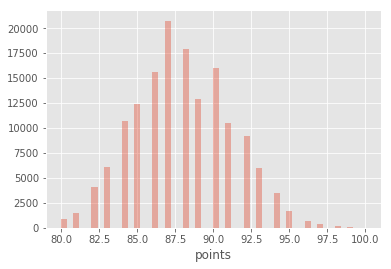

In [4]:
sns.distplot(data.points, kde=False)

In [5]:
def GoodRating(row):
    if row['points'] >= 89:
        val = 1
    else:
        val = 0
    return(val)
data['Good'] = data.apply(GoodRating, axis=1)
data.head()
#data.shape (15k,12)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,Good
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,1


In [6]:
df = data.sample(n=9000)
df = df[['description','Good']]
df.head()

,description,Good
49946,"Opens with pasty, oaky aromas and very little ...",0
146318,"Fresh and cheery, this cranberry-, cherry- and...",0
129128,"Fresh Chardonnay, lightly warm but also tinged...",0
92839,"Dry and elegant, this is not a block­buster. I...",1
132319,One of three properties owned by the Ardurats ...,0


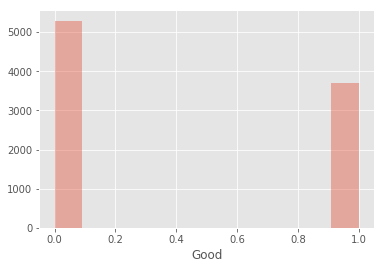

In [7]:
sns.distplot(df.Good, kde=False)

In [8]:
def split_into_lemmas(message):
    message = str(message).lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]

BOW_transform = CountVectorizer(analyzer=split_into_lemmas).fit(df['description'])

In [9]:
BOW = BOW_transform.transform(df['description'])

In [10]:
tfidf_BOW = TfidfTransformer().fit(BOW)

In [11]:
print('inverse document frequnency of the word "to" is:', tfidf_BOW.idf_[BOW_transform.vocabulary_['fruit']])

inverse document frequnency of the word "to" is: 1.88522621934


In [12]:
converted_messages = tfidf_BOW.transform(BOW)

In [13]:
t1 = dt.datetime.now()
spam_detector = MultinomialNB().fit(converted_messages, df['Good'])
t2 = dt.datetime.now()
print('total time taken in training:', (t2-t1))

total time taken in training: 0:00:00.005655


In [14]:
#print('predicted:', spam_detector.predict(tfidf_BOW.transform(BOW[120]))[0])
#print('expected:', df['Good'][120])

In [15]:
target = np.array(df['Good'].tolist())
features = converted_messages
skf = StratifiedKFold(target, n_folds=5)

In [16]:
true_ = []
pred_ = []
for train_index, test_index in skf:
    spam_detector = MultinomialNB().fit(converted_messages[train_index], target[train_index])
    predict = spam_detector.predict(converted_messages[test_index])
    true_.append(target[test_index])
    pred_.append(predict)

In [17]:
TrueLabel = list(itertools.chain(*true_))
PredictedLabel = list(itertools.chain(*pred_))

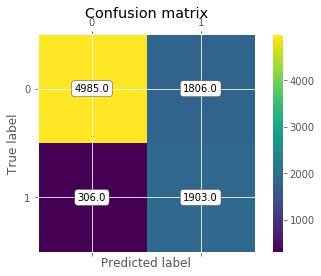

In [18]:
cm = confusion_matrix(PredictedLabel, TrueLabel)
fig, ax = plt.subplots()
im = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
plt.title('Confusion matrix')
fig.colorbar(im)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
TrueLabel = [1 if x==1 else 0 for x in TrueLabel]
PredictedLabel = [1 if x==1 else 0 for x in PredictedLabel]

In [20]:
print('Correlation between the actual and prediction is:', pearsonr(TrueLabel, PredictedLabel)[0], 'with p-value',  ("%.2f" % pearsonr(TrueLabel, PredictedLabel)[1]))

Correlation between the actual and prediction is: 0.520685074534 with p-value 0.00


In [21]:
target_names = ['Good Wine', 'Bad Wine']
print(classification_report(TrueLabel, PredictedLabel, target_names=target_names))

             precision    recall  f1-score   support

  Good Wine       0.73      0.94      0.83      5291
   Bad Wine       0.86      0.51      0.64      3709

avg / total       0.79      0.77      0.75      9000



In [22]:

print('Area under the curve (AUC) is:', roc_auc_score(TrueLabel, PredictedLabel))

Area under the curve (AUC) is: 0.727621121528


In [23]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(TrueLabel, PredictedLabel)
roc_auc = auc(false_positive_rate, true_positive_rate)

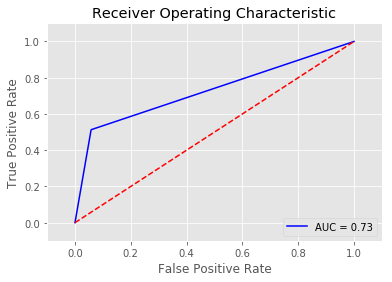

In [24]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Lots of code from
#https://github.com/shubhabrataroy/Thinkful/blob/master/Curriculum/SpamFilter.ipynb